In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/35.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/31.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/33.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/14.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/20.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/18.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/21.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/12.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/28.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/22.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/34.png
/kaggle/in

In [1]:
import numpy as np
np.random.seed(42) 
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary 

In [2]:
num_classes = len(os.listdir('/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train'))

In [3]:
# Custom Dataset Class


class LiverDiseaseDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, _, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label_idx = class_names.index(label)  # Convert label to index
        return image, label_idx

# Get Class Names from Train Directory
class_names = os.listdir('/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train')


In [4]:
train_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train'
training_data = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        images_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            training_data.append([image_path, patient, label])

In [5]:
test_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/test'
testing_data = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        images_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            testing_data.append([image_path, patient, label])

In [6]:
valid_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/test'
validation_data = []

for label in os.listdir(valid_dir):
    label_dir = os.path.join(test_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        valid_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            validation_data.append([image_path, patient, label])

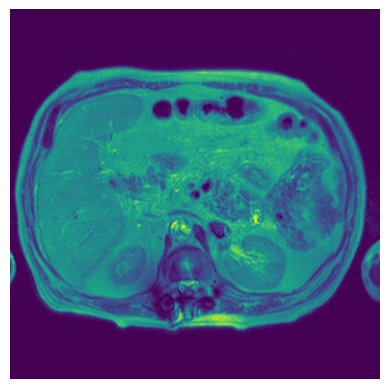

In [7]:
image_path = training_data[0][0]
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

In [8]:
import torchvision.transforms as transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.RandomRotation(degrees=5),    # Random horizontal flip
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [9]:
train_dataset = LiverDiseaseDataset(training_data, transform=data_transforms['train'])
val_dataset = LiverDiseaseDataset(validation_data, transform=data_transforms['val'])
test_dataset = LiverDiseaseDataset(testing_data, transform=data_transforms['test'])

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load GoogleNet
num_classes = 3
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

# Modify the classifier (fully connected layer)
googlenet.fc = nn.Linear(googlenet.fc.in_features, num_classes)

# Move model to GPU if available
googlenet = googlenet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 54.1MB/s]


Epoch 1 | train Loss: 0.6213, Acc: 0.7248
Epoch 1 | val Loss: 2.3043, Acc: 0.5161
Epoch 2 | train Loss: 0.3460, Acc: 0.8620
Epoch 2 | val Loss: 2.8649, Acc: 0.3833
Epoch 3 | train Loss: 0.2045, Acc: 0.9225
Epoch 3 | val Loss: 4.5193, Acc: 0.5161
Epoch 4 | train Loss: 0.1659, Acc: 0.9391
Epoch 4 | val Loss: 6.7600, Acc: 0.5161
Epoch 5 | train Loss: 0.1178, Acc: 0.9562
Epoch 5 | val Loss: 5.1143, Acc: 0.5161
Epoch 6 | train Loss: 0.0347, Acc: 0.9902
Epoch 6 | val Loss: 5.6447, Acc: 0.5161
Epoch 7 | train Loss: 0.0122, Acc: 0.9977
Epoch 7 | val Loss: 6.1507, Acc: 0.5161
Epoch 8 | train Loss: 0.0091, Acc: 0.9981
Epoch 8 | val Loss: 6.4745, Acc: 0.5161
Epoch 9 | train Loss: 0.0084, Acc: 0.9983
Epoch 9 | val Loss: 6.2225, Acc: 0.5161
Epoch 10 | train Loss: 0.0046, Acc: 0.9998
Epoch 10 | val Loss: 6.5838, Acc: 0.5161
Epoch 11 | train Loss: 0.0060, Acc: 0.9991
Epoch 11 | val Loss: 6.9524, Acc: 0.5161
Epoch 12 | train Loss: 0.0042, Acc: 0.9994
Epoch 12 | val Loss: 6.3841, Acc: 0.5161
Epoch 13 |

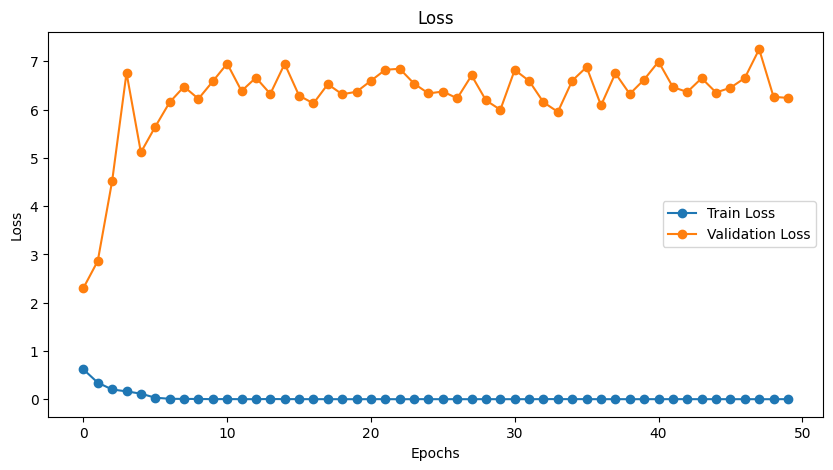

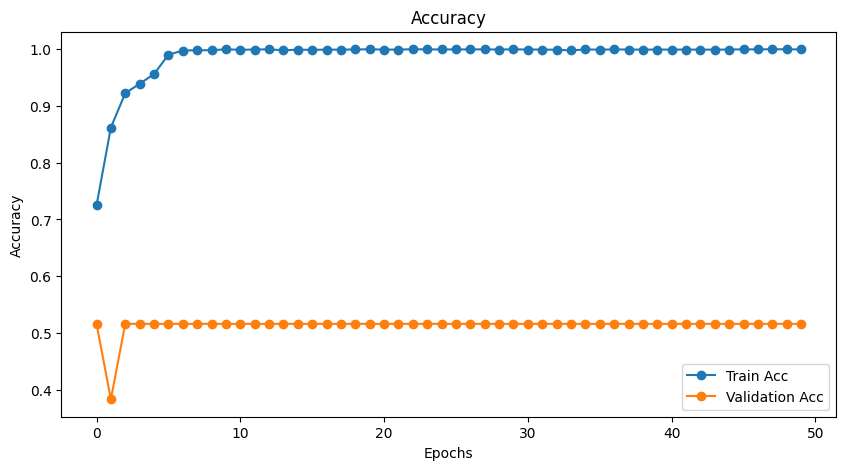

In [11]:
import torch.optim.lr_scheduler as lr_scheduler

num_epochs = 50
train_losses, val_losses, train_acc, val_acc = [], [], [], []

# Define the scheduler (StepLR: reduces LR every 5 epochs by gamma=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            googlenet.train()
            dataloader = train_loader  # Ensure train_loader is defined
        else:
            googlenet.eval()
            dataloader = val_loader  # Ensure val_loader is defined

        running_loss, correct = 0.0, 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = googlenet(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = correct / len(dataloader.dataset)

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_acc.append(epoch_acc)

        print(f'Epoch {epoch+1} | {phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

    # Step the scheduler after each epoch
    scheduler.step()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss'), plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Acc', marker='o')
plt.plot(val_acc, label='Validation Acc', marker='o')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy'), plt.legend()
plt.show()


In [12]:
torch.save(googlenet.state_dict(), "googlenet_model.pth")
print("Model saved successfully!")


Model saved successfully!



Overall Metrics:
Accuracy: 58.28%
Precision: 0.59
Recall (Sensitivity): 0.55
F1-Score: 0.55
Specificity: 0.81

Per-Class Metrics:
Class          Precision Recall (Sensitivity)F1-Score  Specificity
2              0.21      0.39                0.28      0.64      
3              0.70      0.60                0.65      0.90      
1              0.85      0.65                0.73      0.88      


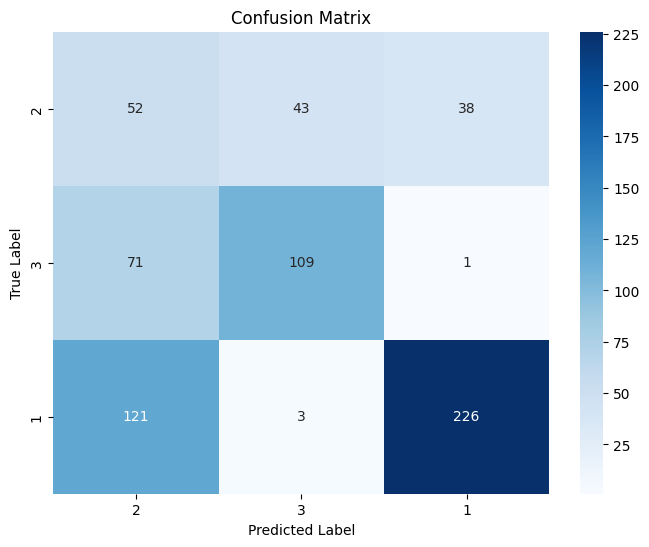

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score

# Ensure model is in evaluation mode
googlenet.eval()

# Store true and predicted labels
y_true = []
y_pred = []

# Run model on test data
with torch.no_grad():
    for inputs, labels in test_loader:  # Ensure test_loader is defined
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = googlenet(inputs)  # Use GoogLeNet model
        _, preds = torch.max(outputs, 1)  # Get class with highest probability

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute overall accuracy
accuracy = accuracy_score(y_true, y_pred)

# Compute per-class metrics
class_report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Extract per-class precision, recall (sensitivity), F1-score
precision_per_class = {class_names[i]: class_report[class_names[i]]["precision"] for i in range(len(class_names))}
recall_per_class = {class_names[i]: class_report[class_names[i]]["recall"] for i in range(len(class_names))}  # Sensitivity
f1_per_class = {class_names[i]: class_report[class_names[i]]["f1-score"] for i in range(len(class_names))}

# Compute specificity manually for each class
specificity_per_class = {}
for i in range(len(class_names)):
    tn = np.sum(cm) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])  # True negatives
    fp = cm[:, i].sum() - cm[i, i]  # False positives
    specificity_per_class[class_names[i]] = tn / (tn + fp) if (tn + fp) > 0 else 0.0

# Compute overall precision, recall, and F1-score
overall_precision = precision_score(y_true, y_pred, average="macro")  # Average across all classes
overall_recall = recall_score(y_true, y_pred, average="macro")  # Sensitivity
overall_f1 = f1_score(y_true, y_pred, average="macro")

# Compute overall specificity (Macro Average)
specificity_values = list(specificity_per_class.values())
overall_specificity = sum(specificity_values) / len(specificity_values)

# Display overall metrics
print(f"\nOverall Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {overall_precision:.2f}")
print(f"Recall (Sensitivity): {overall_recall:.2f}")
print(f"F1-Score: {overall_f1:.2f}")
print(f"Specificity: {overall_specificity:.2f}")

# Display per-class metrics
print("\nPer-Class Metrics:")
print(f"{'Class':<15}{'Precision':<10}{'Recall (Sensitivity)':<20}{'F1-Score':<10}{'Specificity':<10}")
for cls in class_names:
    print(f"{cls:<15}{precision_per_class[cls]:<10.2f}{recall_per_class[cls]:<20.2f}{f1_per_class[cls]:<10.2f}{specificity_per_class[cls]:<10.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
